In [1]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
from monty.serialization import dumpfn, loadfn
from collections import defaultdict

In [3]:
from ase.filters import FrechetCellFilter
from fairchem.core import pretrained_mlip, FAIRChemCalculator
from ase.optimize import LBFGS
from pymatgen.io.ase import AseAtomsAdaptor

predictor = pretrained_mlip.get_predict_unit("uma-m-1p1", device="cuda")
calc = FAIRChemCalculator(predictor, task_name="omat") # use "omat" - inorganic materials

In [4]:
def relaxation_defect(structure): # takes in pymatgen structure
    atoms = structure.to_ase_atoms()
    atoms.calc = calc

    opt = LBFGS(atoms) # Delete this FrechetCellFilter when doing the defect structures
    opt.run(0.01, 1000)

    structure1 = AseAtomsAdaptor.get_structure(atoms)
    energy = atoms.get_potential_energy()

    return structure1, energy 

Load in all relaxed primitive Al Oxide structures
<br>Loop through all Al oxides 
<br>Create function using doped and shakenbreak for each structure
<br>Create function that loops over unpertubed and all disortions and uses MLIP to calc energies - append structure and energies to data dict
<br>get energy difference from unperturbed for each Al oxide and append to dictionary or list for bar chart - can do this manually in loop 
<br>dumpfn the data dict and list of energy differences, or maybe add energy diff to data dict as 'delta_e' key?
<br>Plot bar chart for all metal oxides and their energy relative to unperturbed

In [5]:
from doped.generation import DefectsGenerator
from shakenbreak.input import Distortions

In [6]:
def create_defect(structure):
    defect_gen = DefectsGenerator(structure, extrinsic="Cr", interstitial_gen_kwargs=False) # set large super cell 25 Angstroms 'supercell_gen_kwargs={'min_image_distance':15}'
    valid_keys = []
    for key in defect_gen.keys():
        if  key[:5] == 'Cr_Al' and key[-1] == '0':
            valid_keys.append(key)
    Dist = Distortions(
        defect_entries = {key: defect_gen[key] for key in valid_keys}, # NO Cr_Al_0 for Al2(SO4)3
        # oxidation_states={} # oxidation states predicted are good for now
    )
    distorted_defects_dict, Dist.distortion_metadata = Dist.apply_distortions()
    unperturbed_structures = {}
    distortions = {}
    for key in valid_keys:
        unperturbed_structures[key] = distorted_defects_dict[key[:-2]]['charges'][0]['structures']['Unperturbed']
        distortions[key] = distorted_defects_dict[key[:-2]]['charges'][0]['structures']['distortions']

    return dict(unperturbed_structures), dict(distortions), defect_gen.bulk_supercell

In [7]:
def get_energy(unperturbed_structures, distortions, supercell):
    data = defaultdict(dict)
    supercell_struct, supercell_e = relaxation_defect(supercell)
    data['supercell'] = {
        'structure': supercell_struct,
        'energy': supercell_e
    }
    
    for site, unperturbed_structure in unperturbed_structures.items():
        data[site] = defaultdict(dict)
        data[site]['unperturbed'] = defaultdict(dict)
        unperturbed_structure1, unp_energy = relaxation_defect(unperturbed_structure)
        data[site]['unperturbed'] = {
        'structure':unperturbed_structure1,
        'energy': unp_energy,
        'distortion_amount':'N/A'
        }
        data[site]['distortions'] = defaultdict(dict)
        for key, structure in distortions[site].items():
            structure1, energy = relaxation_defect(structure)
            if key != 'Rattled':
                distortion_amount = float(key.split("_")[-1].replace("%", "").replace("-", "-"))/100
            else:
                distortion_amount = 0
            data[site]['distortions'][key] = {
                'structure': structure1,
                'energy': energy,
                'distortion_amount': distortion_amount,
                'delta_e': energy - unp_energy
            }
    
    return dict(data)

In [8]:
Al_prim = loadfn('../data/relaxed_Al_prim.json')
del Al_prim['mp-554152']

In [ ]:
data = {}
for key, val in Al_prim.items():
    unperturbed_structures, distortions, supercell = create_defect(val['structure'])
    mini_data = get_energy(unperturbed_structures, distortions, supercell) # add in host supercell relaxation
    data[key] = mini_data


Generating DefectEntry objects: 100.0%|███████████████████████████████████████████████████████████████| [01:19,   1.26it/s]


Vacancies                 Guessed Charges        Conv. Cell Coords    Wyckoff
------------------------  ---------------------  -------------------  ---------
v_Al                      [+1,0,-1,-2,-3]        [0.116,0.637,0.375]  4e
v_P_C1_O1.49              [+1,0,-1,-2,-3,-4,-5]  [0.203,0.664,0.016]  4e
v_P_C1_O1.50O1.60         [+1,0,-1,-2,-3,-4,-5]  [0.145,0.544,0.718]  4e
v_P_C1_O1.50O1.61         [+1,0,-1,-2,-3,-4,-5]  [0.415,0.112,0.213]  4e
v_O_C1_P1.49              [+2,+1,0,-1]           [0.822,0.257,0.090]  4e
v_O_C1_P1.50Al1.90O2.52   [+2,+1,0,-1]           [0.194,0.158,0.148]  4e
v_O_C1_P1.50Al1.90O2.53a  [+2,+1,0,-1]           [0.576,0.114,0.107]  4e
v_O_C1_P1.50Al1.90O2.53b  [+2,+1,0,-1]           [0.165,0.619,0.608]  4e
v_O_C1_P1.50Al1.91        [+2,+1,0,-1]           [0.068,0.655,0.141]  4e
v_O_C1_P1.50Al1.92        [+2,+1,0,-1]           [0.055,0.515,0.335]  4e
v_O_C1_P1.60              [+2,+1,0,-1]           [0.853,0.421,0.100]  4e
v_O_C1_P1.61              [+2,+1,0,-1] 

Generating distorted defect structures...0.0%|                                                            | [00:00,  ?it/s]


Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0


Generating distorted defect structures...100.0%|██████████████████████████████████████████████████████| [00:00,   4.60it/s]


       Step     Time          Energy          fmax
LBFGS:    0 16:32:05    -1143.208343        0.007806
       Step     Time          Energy          fmax
LBFGS:    0 16:32:10    -1143.583089        1.963626
LBFGS:    1 16:32:15    -1143.738302        1.310549
LBFGS:    2 16:32:19    -1143.871816        0.596801
LBFGS:    3 16:32:24    -1143.919652        0.378782
LBFGS:    4 16:32:29    -1143.947652        0.303747
LBFGS:    5 16:32:34    -1143.967885        0.176548
LBFGS:    6 16:32:39    -1143.978887        0.213258
LBFGS:    7 16:32:44    -1143.989034        0.194240
LBFGS:    8 16:32:49    -1143.996328        0.099969
LBFGS:    9 16:32:54    -1144.000097        0.103250
LBFGS:   10 16:32:59    -1144.002416        0.068624
LBFGS:   11 16:33:04    -1144.004339        0.079791
LBFGS:   12 16:33:08    -1144.005819        0.065221
LBFGS:   13 16:33:13    -1144.007238        0.053522
LBFGS:   14 16:33:18    -1144.008581        0.055531
LBFGS:   15 16:33:23    -1144.009695        0.0627

Generating DefectEntry objects: 100.0%|███████████████████████████████████████████████████████████████| [00:24,   4.00it/s]


Vacancies    Guessed Charges    Conv. Cell Coords    Wyckoff
-----------  -----------------  -------------------  ---------
v_Li         [+1,0,-1]          [0.000,0.000,0.000]  3a
v_Al         [+1,0,-1,-2,-3]    [0.000,0.000,0.500]  3b
v_O          [+2,+1,0,-1]       [0.000,0.000,0.238]  6c

Substitutions    Guessed Charges     Conv. Cell Coords    Wyckoff
---------------  ------------------  -------------------  ---------
Li_Al            [0,-1,-2]           [0.000,0.000,0.500]  3b
Li_O             [+3,+2,+1,0]        [0.000,0.000,0.238]  6c
Al_Li            [+2,+1,0]           [0.000,0.000,0.000]  3a
Al_O             [+5,+4,+3,+2,+1,0]  [0.000,0.000,0.238]  6c
O_Li             [0,-1,-2,-3]        [0.000,0.000,0.000]  3a
O_Al             [0,-1,-2,-3,-4,-5]  [0.000,0.000,0.500]  3b
Cr_Li            [+5,+4,+3,+2,+1,0]  [0.000,0.000,0.000]  3a
Cr_Al            [+3,+2,+1,0,-1]     [0.000,0.000,0.500]  3b
Cr_O             [+5,+4,+3,+2,+1,0]  [0.000,0.000,0.238]  6c

The number in the Wycko

Generating distorted defect structures...100.0%|██████████████████████████████████████████████████████| [00:00,   7.62it/s]



Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0
       Step     Time          Energy          fmax
LBFGS:    0 16:41:10     -688.263262        0.001873
       Step     Time          Energy          fmax
LBFGS:    0 16:41:15     -688.903069        1.693455
LBFGS:    1 16:41:21     -689.100182        1.030940
LBFGS:    2 16:41:27     -689.237084        0.216185
LBFGS:    3 16:41:32     -689.245095        0.138487
LBFGS:    4 16:41:38     -689.250252        0.080500
LBFGS:    5 16:41:44     -689.252907        0.060100
LBFGS:    6 16:41:50     -689.254433        0.048851
LBFGS:    7 16:41:55     -689.255120        0.028122
LBFGS:    8 16:42:01     -689.255455        0.020978
LBFGS:    9 16:42:07     -689.255791        0.018542
LBFGS:   10 16:42:13     -689.256051        0.021001
LBFGS:   11 16:42:19     -689.256295        0.013582
LBFGS:   12 16:42:25     -689.256432        0.011444
LBFGS:   13 16:42:30     

Generating DefectEntry objects: 100.0%|███████████████████████████████████████████████████████████████| [00:15,   6.64it/s]


Vacancies    Guessed Charges    Conv. Cell Coords    Wyckoff
-----------  -----------------  -------------------  ---------
v_Al         [+1,0,-1,-2,-3]    [0.000,0.500,0.095]  2b
v_Cl         [+1,0,-1]          [0.000,0.000,0.713]  2a
v_O          [+2,+1,0,-1]       [0.000,0.000,0.045]  2a

Substitutions    Guessed Charges     Conv. Cell Coords    Wyckoff
---------------  ------------------  -------------------  ---------
Al_Cl            [+4,+3,+2,+1,0]     [0.000,0.000,0.713]  2a
Al_O             [+5,+4,+3,+2,+1,0]  [0.000,0.000,0.045]  2a
Cl_Al            [0,-1,-2,-3,-4]     [0.000,0.500,0.095]  2b
Cl_O             [+1,0]              [0.000,0.000,0.045]  2a
O_Al             [0,-1,-2,-3,-4,-5]  [0.000,0.500,0.095]  2b
O_Cl             [0,-1]              [0.000,0.000,0.713]  2a
Cr_Al            [+3,+2,+1,0,-1]     [0.000,0.500,0.095]  2b
Cr_Cl            [+4,+3,+2,+1,0]     [0.000,0.000,0.713]  2a
Cr_O             [+5,+4,+3,+2,+1,0]  [0.000,0.000,0.045]  2a

The number in the Wycko

Generating distorted defect structures...100.0%|██████████████████████████████████████████████████████| [00:00,  16.30it/s]



Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0
       Step     Time          Energy          fmax
LBFGS:    0 16:46:54     -316.789552        0.000616
       Step     Time          Energy          fmax
LBFGS:    0 16:46:55     -317.925487        2.179511
LBFGS:    1 16:46:57     -318.071182        1.064940
LBFGS:    2 16:46:59     -318.148045        0.383009
LBFGS:    3 16:47:01     -318.164131        0.295001
LBFGS:    4 16:47:03     -318.180954        0.185186
LBFGS:    5 16:47:05     -318.186005        0.144772
LBFGS:    6 16:47:07     -318.189522        0.097028
LBFGS:    7 16:47:09     -318.191513        0.097895
LBFGS:    8 16:47:11     -318.193153        0.096802
LBFGS:    9 16:47:13     -318.194084        0.059689
LBFGS:   10 16:47:15     -318.194687        0.050501
LBFGS:   11 16:47:17     -318.195148        0.038322
LBFGS:   12 16:47:19     -318.195557        0.035037
LBFGS:   13 16:47:20     

Generating DefectEntry objects: 100.0%|███████████████████████████████████████████████████████████████| [00:22,   4.47it/s]


Vacancies    Guessed Charges    Conv. Cell Coords    Wyckoff
-----------  -----------------  -------------------  ---------
v_Sm         [+1,0,-1,-2,-3]    [0.491,0.250,0.464]  4c
v_Al         [+1,0,-1,-2,-3]    [0.000,0.000,0.500]  4b
v_O_C1       [+2,+1,0,-1]       [0.219,0.038,0.218]  8d
v_O_Cs       [+2,+1,0,-1]       [0.572,0.250,0.013]  4c

Substitutions    Guessed Charges     Conv. Cell Coords    Wyckoff
---------------  ------------------  -------------------  ---------
Sm_Al            [+1,0,-1]           [0.000,0.000,0.500]  4b
Sm_O_C1          [+5,+4,+3,+2,+1,0]  [0.219,0.038,0.218]  8d
Sm_O_Cs          [+5,+4,+3,+2,+1,0]  [0.572,0.250,0.013]  4c
Al_Sm            [+1,0,-1]           [0.491,0.250,0.464]  4c
Al_O_C1          [+5,+4,+3,+2,+1,0]  [0.219,0.038,0.218]  8d
Al_O_Cs          [+5,+4,+3,+2,+1,0]  [0.572,0.250,0.013]  4c
O_Sm             [0,-1,-2,-3,-4,-5]  [0.491,0.250,0.464]  4c
O_Al             [0,-1,-2,-3,-4,-5]  [0.000,0.000,0.500]  4b
Cr_Sm            [+3,+2,+1,0,

Generating distorted defect structures...100.0%|██████████████████████████████████████████████████████| [00:00,   6.81it/s]



Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0
       Step     Time          Energy          fmax
LBFGS:    0 16:49:20     -634.784229        0.008151
       Step     Time          Energy          fmax
LBFGS:    0 16:49:24     -635.443948        1.687024
LBFGS:    1 16:49:27     -635.618677        0.923077
LBFGS:    2 16:49:31     -635.708765        0.236172
LBFGS:    3 16:49:34     -635.719431        0.166745
LBFGS:    4 16:49:38     -635.732630        0.131195
LBFGS:    5 16:49:42     -635.736490        0.095735
LBFGS:    6 16:49:45     -635.739847        0.068551
LBFGS:    7 16:49:49     -635.741617        0.049313
LBFGS:    8 16:49:53     -635.743417        0.044873
LBFGS:    9 16:49:57     -635.745020        0.048013
LBFGS:   10 16:50:00     -635.746271        0.042863
LBFGS:   11 16:50:04     -635.746988        0.028761
LBFGS:   12 16:50:08     -635.747400        0.023708
LBFGS:   13 16:50:11     

Generating DefectEntry objects: 100.0%|███████████████████████████████████████████████████████████████| [00:24,   4.08it/s]


Vacancies       Guessed Charges        Conv. Cell Coords    Wyckoff
--------------  ---------------------  -------------------  ---------
v_Al            [+1,0,-1,-2,-3]        [0.000,0.000,0.000]  2a
v_W             [+1,0,-1,-2,-3,-4,-5]  [0.000,0.500,0.500]  2c
v_O_C2v_Al1.89  [+2,+1,0,-1]           [0.000,0.294,0.000]  4i
v_O_C2v_W1.95   [+2,+1,0,-1]           [0.305,0.500,0.500]  4h

Substitutions    Guessed Charges              Conv. Cell Coords    Wyckoff
---------------  ---------------------------  -------------------  ---------
Al_O_C2v_Al1.89  [+5,+4,+3,+2,+1,0]           [0.000,0.294,0.000]  4i
Al_W             [0,-1,-2]                    [0.000,0.500,0.500]  2c
Al_O_C2v_W1.95   [+5,+4,+3,+2,+1,0]           [0.305,0.500,0.500]  4h
W_Al             [+3,+2,+1,0,-1]              [0.000,0.000,0.000]  2a
W_O_C2v_Al1.89   [+8,+7,+6,+5,+4,+3,+2,+1,0]  [0.000,0.294,0.000]  4i
W_O_C2v_W1.95    [+8,+7,+6,+5,+4,+3,+2,+1,0]  [0.305,0.500,0.500]  4h
O_Al             [0,-1,-2,-3,-4,-5]  

Generating distorted defect structures...100.0%|██████████████████████████████████████████████████████| [00:00,   9.92it/s]



Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0
       Step     Time          Energy          fmax
LBFGS:    0 16:53:03     -634.132811        0.001247
       Step     Time          Energy          fmax
LBFGS:    0 16:53:07     -635.135189        1.882395
LBFGS:    1 16:53:11     -635.264509        0.936349
LBFGS:    2 16:53:15     -635.360428        0.311144
LBFGS:    3 16:53:19     -635.380060        0.256637
LBFGS:    4 16:53:23     -635.396378        0.211485
LBFGS:    5 16:53:27     -635.402899        0.081707
LBFGS:    6 16:53:31     -635.406317        0.064079
LBFGS:    7 16:53:36     -635.407950        0.068977
LBFGS:    8 16:53:40     -635.409168        0.058932
LBFGS:    9 16:53:44     -635.410046        0.033222
LBFGS:   10 16:53:48     -635.410670        0.028813
LBFGS:   11 16:53:52     -635.411049        0.023208
LBFGS:   12 16:53:56     -635.411280        0.018672
LBFGS:   13 16:54:00     

Generating DefectEntry objects: 100.0%|███████████████████████████████████████████████████████████████| [01:08,   1.46it/s]


Vacancies                 Guessed Charges        Conv. Cell Coords    Wyckoff
------------------------  ---------------------  -------------------  ---------
v_K_C1_O2.80O2.88O2.92    [+1,0,-1]              [0.319,0.682,0.191]  2a
v_K_C1_O2.80O2.88O2.93    [+1,0,-1]              [0.682,0.318,0.309]  2a
v_Al_C1_O1.87O1.90O1.94   [+1,0,-1,-2,-3]        [0.261,0.400,0.491]  2a
v_Al_C1_O1.87O1.90O1.95   [+1,0,-1,-2,-3]        [0.739,0.600,0.009]  2a
v_P_C1_O1.50O1.53O1.63a   [+1,0,-1,-2,-3,-4,-5]  [0.374,0.098,0.419]  2a
v_P_C1_O1.50O1.53O1.63b   [+1,0,-1,-2,-3,-4,-5]  [0.374,0.403,0.919]  2a
v_P_C1_O1.52O1.64P2.89a   [+1,0,-1,-2,-3,-4,-5]  [0.066,0.369,0.062]  2a
v_P_C1_O1.52O1.64P2.89b   [+1,0,-1,-2,-3,-4,-5]  [0.067,0.131,0.562]  2a
v_O_C1_P1.50Al1.87O2.52a  [+2,+1,0,-1]           [0.350,0.092,0.230]  2a
v_O_C1_P1.50Al1.87O2.52b  [+2,+1,0,-1]           [0.350,0.407,0.730]  2a
v_O_C1_P1.52Al1.90O2.51a  [+2,+1,0,-1]           [0.177,0.396,0.247]  2a
v_O_C1_P1.52Al1.90O2.51b  [+2,+1,0,-1] 

Generating distorted defect structures...50.0%|███████████████████████████▌                           | [00:00,   8.26it/s]


Defect: Cr_Al_C1_O1.87O1.90O1.94
Number of missing electrons in neutral state: 0

Defect Cr_Al_C1_O1.87O1.90O1.94 in charge state: 0. Number of distorted neighbours: 0

Defect: Cr_Al_C1_O1.87O1.90O1.95
Number of missing electrons in neutral state: 0

Defect Cr_Al_C1_O1.87O1.90O1.95 in charge state: 0. Number of distorted neighbours: 0


Generating distorted defect structures...100.0%|██████████████████████████████████████████████████████| [00:00,   9.67it/s]


       Step     Time          Energy          fmax
LBFGS:    0 16:57:33     -933.185730        0.008948
       Step     Time          Energy          fmax
LBFGS:    0 16:57:38     -933.707434        1.918925
LBFGS:    1 16:57:43     -933.849692        1.334492
LBFGS:    2 16:57:47     -933.956564        0.455968
LBFGS:    3 16:57:52     -934.008826        0.406716
LBFGS:    4 16:57:57     -934.037009        0.285014
LBFGS:    5 16:58:02     -934.058371        0.211787
LBFGS:    6 16:58:07     -934.070944        0.170181
LBFGS:    7 16:58:11     -934.078436        0.133217
LBFGS:    8 16:58:16     -934.084067        0.122052
LBFGS:    9 16:58:21     -934.089789        0.113846
LBFGS:   10 16:58:26     -934.095023        0.114782
LBFGS:   11 16:58:30     -934.098685        0.096651
LBFGS:   12 16:58:35     -934.101202        0.084886
LBFGS:   13 16:58:40     -934.103400        0.080157
LBFGS:   14 16:58:45     -934.105704        0.080600
LBFGS:   15 16:58:50     -934.107565        0.0690

Generating DefectEntry objects: 100.0%|███████████████████████████████████████████████████████████████| [00:11,   8.38it/s]


Vacancies                Guessed Charges        Conv. Cell Coords    Wyckoff
-----------------------  ---------------------  -------------------  ---------
v_Cs_C2_O3.22            [+1,0,-1]              [0.297,0.297,0.000]  3a
v_Cs_C2_O3.32            [+1,0,-1]              [0.464,0.464,0.500]  3b
v_Al                     [+1,0,-1,-2,-3]        [0.690,0.690,0.000]  3a
v_N_C1_O1.24O1.33Al2.90  [+1,0,-1,-2,-3,-4,-5]  [0.555,0.242,0.245]  6c
v_N_C1_O1.24O1.33Al2.93  [+1,0,-1,-2,-3,-4,-5]  [0.089,0.348,0.405]  6c
v_N_C2                   [+1,0,-1,-2,-3,-4,-5]  [0.904,0.904,0.000]  3a
v_O_C1_N1.24O2.18O2.20   [+2,+1,0,-1]           [0.321,0.614,0.108]  6c
v_O_C1_N1.24O2.18O3.27   [+2,+1,0,-1]           [0.185,0.385,0.330]  6c
v_O_C1_N1.25O2.20O2.23   [+2,+1,0,-1]           [0.335,0.032,0.041]  6c
v_O_C1_N1.25O2.20O2.93   [+2,+1,0,-1]           [0.491,0.305,0.242]  6c
v_O_C1_N1.30             [+2,+1,0,-1]           [0.205,0.090,0.274]  6c
v_O_C1_N1.33Al1.87       [+2,+1,0,-1]           [0.4

Generating distorted defect structures...0.0%|                                                            | [00:00,  ?it/s]

In [108]:
previous = loadfn('../data/matching_AlCr_ox.json')

In [109]:
for key, val in Al_prim.items():
    data[key]['formula'] = previous[key]['formula']

In [133]:
for key,val in data_load.items(): # goes through mp id's
    min_energy = [float('inf'), '']
    for key1, val1 in val.items(): # goes through supercell and sites
        if key1 != 'supercell' and key1 != 'formula':
            for key2, val2 in val1.items(): 
                if key2 == 'unperturbed':
                    if val2['energy'] < min_energy[0]:
                        min_energy[0] = val2['energy']
                        min_energy[1] = [key1, key2]
                else:
                    for key3, val3 in val2.items():
                        if val3['energy'] < min_energy[0]:
                            min_energy[0] = val3['energy']
                            min_energy[1] = [key1, key2, key3]
    data[key]['minimum energy site'] = {
        'energy': min_energy[0],
        'information': min_energy[1]
    }

In [134]:
dumpfn(data, '../data/doped_defect_energies.json')

In [135]:
data_load = loadfn('../data/doped_defect_energies2.json')

In [143]:
compounds = []
delta_e = []
count = 0
for key, val in data_load.items():
    min_energy = float('inf')
    for key1, val1 in val.items():
        if key1 != 'supercell' and key1 != 'formula' and key1 != 'minimum energy site':
            for key2, val2 in val1.items():
                if key2 != 'unperturbed':
                    for key3, val3 in val2.items():
                        if val3['energy'] < min_energy:
                            min_energy = val3['energy']
                            min_delta_e = val3['delta_e'] # filters for lowest energy rattled site, may be higher or lower than unperturbed
    delta_e.append(min_delta_e)
    compounds.append(data_load[key]['formula'])

In [144]:
import matplotlib.pyplot as plt

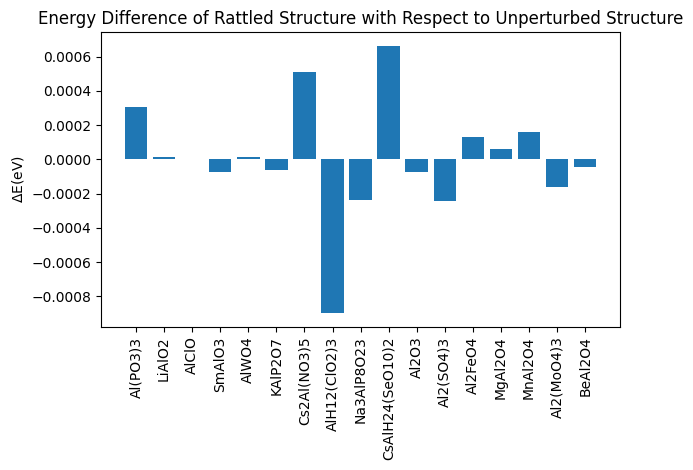

In [145]:
fig, ax = plt.subplots()
bars = ax.bar(compounds, delta_e)  # Assuming you have these lists already

# Add labels on top of each bar
ax.set_title("Energy Difference of Rattled Structure with Respect to Unperturbed Structure")
ax.set_ylabel("$\Delta$E(eV)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("../figures/energy_difference_plot.png", dpi=300, bbox_inches='tight')

plt.show()